<a href="https://colab.research.google.com/github/jouinisihem/Multimodal-Medical-Visual-Question-Answering-VQA-/blob/main/Mod%C3%A8le(swin%2Bbiobert).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importez les bibliothèques nécessaires et configurez l'environnement :

In [ ]:
#Installer transformer
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
#Importation des librairies necessaires
import os

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
#Le score F1 peut être interprété comme une moyenne harmonique de la précision .F1 atteint sa meilleure valeur à 1 et son pire score à 0. 
#Accuracy_score est utilisée pour calculer la précision de la faction ou du nombre de prédictions correctes.
#la precision est une mesure de la pertinence des résultats, tandis que le recall est une mesure du nombre de résultats réellement pertinents retournés.

from sklearn.metrics import accuracy_score, f1_score , precision_score, recall_score
from sklearn import preprocessing
from datasets import load_dataset, set_caching_enabled
from datasets.arrow_dataset import DatasetTransformationNotAllowedError
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass

from transformers import (
    # Prétraitement 
    AutoTokenizer, AutoFeatureExtractor,
    # Modèles de texte et d'image (maintenant, les transformateurs d'image comme ViTModel, DeiTModel, BEiT peuvent également être chargés à l'aide d'AutoModel)
    AutoModel,            
    # Training / Evaluation
    TrainingArguments, Trainer,
    #FACULTATIF : si vous souhaitez avoir plus d'informations sur ce qui se passe, activez le logger comme suit
    logging )
#nltk est une bibliothèque open source écrit en Python dédiée au traitement du langage naturel (langage anglais)
import nltk
nltk.download('wordnet')
#WordNet est une base de données lexicale des relations sémantiques entre les mots dans plus de 200 langues. 
#WordNet relie les mots dans des relations sémantiques comprenant des synonymes , des hyponymes et des méronymes .
nltk.download('all')

from copy import deepcopy


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Informations supplémentaires lors de l'utilisation de cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda:0
Tesla T4


In [ ]:
#Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Charger et instancier l'ensemble de données d'entraînement et d'évaluation présent au format CSV
dataset = load_dataset(
    "csv", 
    data_files={
        "training": os.path.join('/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/data_train.csv'),
        "validation": os.path.join('/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/data_val.csv'),
        "test": os.path.join('/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/data_test.csv')

    }
)
# Charger l'espace de toutes les réponses possibles
with open(os.path.join('/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/answer_space.txt')) as f:
    answer_space = f.read().splitlines()

# Puisque nous modélisons la tâche VQA comme un problème de classification multiclasse,
# nous devons créer les étiquettes à partir des réponses réelles
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans) for ans in examples['answer']           
        ]
    },
    batched=True
)
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d074ad5480c7cffb/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    training: Dataset({
        features: ['img_id', 'question', 'answer', 'label'],
        num_rows: 12791
    })
    validation: Dataset({
        features: ['img_id', 'question', 'answer', 'label'],
        num_rows: 1999
    })
    test: Dataset({
        features: ['img_id', 'question', 'answer', 'label'],
        num_rows: 499
    })
})

# Créer un assembleur multimodal pour l'ensemble de données :

Cela sera utilisé dans Trainer() pour créer automatiquement le Dataloader à partir de l'ensemble de données afin de transmettre les entrées au modèle.

L'assembleur traitera la question (texte) et l'image, et renverra le tokenisation de texte (avec des masques d'attention) et les caractéristiques de l'image  (essentiellement, les valeurs de pixel). Ceux-ci seront introduits dans notre modèle de transformateur multimodal pour répondre aux questions.


In [ ]:
# Le décorateur de dataclass est utilisé pour générer automatiquement des méthodes spéciales pour les classes,
# incluant __init__, __str__ et __repr__. Cela aide à réduire certains codes passe-partout.

@dataclass
class MultimodalCollator:
    # Nous utilisons AutoTokenizer et AutoFeatureExtractor des transformateurs pour convertir les images brutes et les questions en entrées 
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
      """la fonction tokenize_text renvoie spécifiquement un dictionnaire de valeurs au lieu d'une simple liste de valeurs."""
      encoded_text = self.tokenizer(
            text=texts,
            # PyTorch représente les données sous forme de tableaux multidimensionnels, similaires aux tableaux NumPy, appelés « Tensor ». 
            return_tensors='pt', #return_tensors = "pt" est juste pour que le tokenizer retourne des tenseurs PyTorch. 
            #Les entrées par lots sont souvent de longueurs différentes,Le padding et le truncation sont des stratégies permettant de traiter ce problème.
            #Le padding ajoute un jeton de remplissage spécial pour garantir que les séquences plus courtes auront la même longueur que la séquence la plus longue 
            #d'un lot ou que la longueur maximale acceptée par le modèle(512).
            padding='longest',
            #truncation==>(fonctionne  dans l'autre sens de padding )
            truncation=True,
            max_length=24,
            # les séquences seront encodées avec les jetons spéciaux relatifs à leur modèle.
            add_special_tokens = True,
            return_token_type_ids=True,
            #Le masque d'attention est un tenseur binaire indiquant la position des indices de padding afin que le modèle ne s'en occupe pas. 
            # Pour le BertTokenizer, 1 indique une valeur qui doit être prise en compte, tandis que 0 indique une valeur rembourrée
            return_attention_mask=True,         
        )
      return {
            # La fonction squeeze réduit les dimensions de longueur 1 du tenseur 
            # Par exemple, pour la forme d'entrée suivante : AX1XBXCX1XD, la fonction squeeze(input) renverra la sortie AXBXCXD 
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join('/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/images', img_id + ".jpg")).convert('RGB') for img_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            #La fonction isinstance() vérifie si l'objet (raw_batch_dict) est une instance ou une sous-classe de la classe dict (second argument).
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['img_id']
                if isinstance(raw_batch_dict, dict) else
                [i['img_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

# Définition de l'architecture du modèle VQA multimodal:
Les modèles multimodaux peuvent prendre diverses formes pour capturer des informations à partir des modalités de texte et d'image. Ici, nous explorons les modèles "Fusion", qui fusionnent les informations de l'encodeur de texte et de l'encodeur d'image pour effectuer la tâche en aval (réponse visuelle aux questions).

Notre modèle multimodal comprenant :

*   **Un encodeur de texte :** qui peut être un modèle de transformateur basé sur du texte (comme BERT, RoBERTa, etc.) .

*  **Un encodeur d'image :**  qui peut être un transformateur d'image (comme ViT, Deit, BeIT, etc.). 
*  **Une couche de fusion simple  :**qui concatène les caractéristiques textuelles et d'image et les fait passer à travers une couche linéaire pour générer une sortie intermédiaire .

* **Un classificateur :**, qui est un réseau entièrement connecté avec une sortie ayant les dimensions égales à celle de l'espace de réponse


Puisque nous modélisons la tâche VQA comme une classification multi-classes, il est naturel d'utiliser *Cross-Entropy Loss* comme fonction de perte.



In [ ]:
#nn.Module est la classe de base du réseau neuronal de Pytorch
class MultimodalVQAModel(nn.Module):
    def __init__(self, pretrained_text_name, pretrained_image_name, num_labels= len(answer_space),intermediate_dim= 512,dropout=0.5):
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        #encodeurs d'image et de texte
        
        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)

        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        # Couche de fusion 
        ##Le module "Sequential" est un module "container" qui permet de définir un réseau feed forward
        self.fusion = nn.Sequential(
            #text_encoder.config.hidden_size nous permet d'obtenir la taille des sorties brutes d'encodeur de texte
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            ## la fonction ReLu (Unité Linéaire Rectifiée) qui est une fonction d'activation qui permet d’effectuer un filtre sur nos données. 
            ## elle laisse passer les valeurs positives (x > 0) dans les couches suivantes du réseau de neurones. 
            nn.ReLU(),
            #"" La méthode du dropout consiste à  désactiver  des sorties de neurones aléatoirement(0.5 pour les couches cachées)
            nn.Dropout(0.5),
        )

        #classifieur
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        ## fonction de perte
        self.criterion = nn.CrossEntropyLoss()

    # forward pass en tant que méthode
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )

        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

#Définir une fonction pour créer les modèles VQA multimodaux avec leurs assembleurs(Dataloader) :
Nous prévoyons d'expérimenter plusieurs encodeurs de texte et d'image pré-entraînés pour notre modèle VQA. 

Ainsi, il est raisonnable d'implémenter une fonction pour créer les assembleurs correspondants avec les modèles respectifs(les tokenizers, les featureizers et les modèles doivent être chargés à partir des mêmes checkpoints pré-formés)
 


In [ ]:
def createMultimodalVQACollatorAndModel(text='dmis-lab/biobert-v1.1', image='microsoft/swin-tiny-patch4-window7-224'):
    # Initialisez le tokenizer de texte et l'extracteur de caractéristiques d'image corrects, et utilisez-les pour créer l'assembleur(Dataloader)
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image) 
    multi_collator = MultimodalCollator(tokenizer=tokenizer,preprocessor=preprocessor)
    
    # Instancier et nitialiser le modèle multimodal avec les modèles pré-entraînés appropriés
    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

#Métriques de performance de la réponse visuelle aux questions :

 

In [ ]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Renvoie le score de similarité Wu-Palmer.
    Plus précisément, il calcule :
    max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
    où interp est un 'champ d'interprétation'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Parfois, la réponse a la forme word\d+:wordid.
        Si c'est le cas, nous retournons le mot et le poids vers le bas
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # ce sont les mêmes
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # nous prenons l'interprétation la plus optimiste
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # Nous devons utiliser les champs sémantiques et donc nous réduisons la pondération
    # sauf si le score est élevé, ce qui indique que les deux sont des synonymes
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score

In [ ]:
# Wrapper autour de la fonction wup_measure(...) pour traiter les entrées par batch (lots)
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [ ]:
# Fonction pour calculer toutes les mesures de performance pertinentes, à transmettre au trainer
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "accuracy": accuracy_score(labels, preds),
        "precison": precision_score(labels, preds,average='macro')*10,
        "recall" : recall_score(labels, preds,average='macro')*10,
        "f1": f1_score(labels, preds,average='macro')*10,
    }

#Entraînement du modèle VQA multimodal sur l'ensemble de données

Nous arrivons enfin à la partie où nous utilisons les fonctions définies précédemment pour initialiser notre modèle multimodal et l'entraîner à l'aide du Trainer  pour extraire la plupart du code nécessaire à la mise en place d'une boucle d'entraînement PyTorch.
**Définir les arguments nécessaires à la formation**

 Les hyperparamètres tels que training epochs, batch size, etc., sont transmis au formateur en définissant les valeurs correspondantes dans les TrainingArguments.



In [ ]:
multi_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/checkpoint",
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=15,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,  #le pas d'apprentissage
    metric_for_best_model='accuracy',
    load_best_model_at_end=True,
    #Étant donné que les modèles sont volumineux, enregistrez uniquement les 3 derniers checkpoints à un moment donné pendant l'entraînement
    save_total_limit=3,             
    remove_unused_columns=False,
    dataloader_num_workers=8,
    do_predict=True,
)

# Initialiser l'assembleur réel et le modèle multimodal
collator, model = createMultimodalVQACollatorAndModel("dmis-lab/biobert-v1.1", "microsoft/swin-tiny-patch4-window7-224")

# Initialiser le formateur avec l'ensemble de données, l'assembleur, le modèle, les hyperparamètres et les métriques d'évaluation
multi_trainer = Trainer(
	model,
	multi_args,
	train_dataset=dataset['training'],
	eval_dataset=dataset['validation'],

	data_collator=collator,
	compute_metrics=compute_metrics
)

# Démarrer training loop
train_multi_metrics = multi_trainer.train()
multi_trainer.save_model()

# Exécuter le modèle sur l'ensemble d'évaluation pour obtenir les métriques finales
eval_multi_metrics = multi_trainer.evaluate()


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-pack

Epoch,Training Loss,Validation Loss,Wups,Accuracy,Precison,Recall,F1
1,3.780200,2.724222,0.466396,0.464732,0.230191,0.305350,0.229163
2,2.602300,2.448056,0.550867,0.548774,0.453690,0.525323,0.452674
3,2.311700,2.370576,0.567037,0.565783,0.497888,0.582951,0.502560
4,2.112100,2.341693,0.576371,0.574287,0.568381,0.637933,0.564523
5,1.962100,2.338809,0.589031,0.587794,0.544983,0.700208,0.571219
6,1.825400,2.344620,0.596324,0.594797,0.636772,0.721223,0.634549
7,1.709400,2.355570,0.599841,0.598299,0.685672,0.758832,0.669470
8,1.596600,2.403765,0.601534,0.600300,0.644862,0.754744,0.649811
9,1.505100,2.431965,0.605032,0.603802,0.656813,0.744442,0.646140
10,1.423900,2.444492,0.610514,0.609305,0.689066,0.801717,0.691639


***** Running Evaluation *****
  Num examples = 1999
  Batch size = 32
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to /content/drive/MyDrive/Sihem Jouini /VQA-Med2019/checkpoint/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
eval_multi_metrics

{'eval_loss': 2.374356985092163,
 'eval_wups': 0.5935319645781548,
 'eval_accuracy': 0.5917958979489745,
 'eval_precison': 0.5633394518848914,
 'eval_recall': 0.6761811012962928,
 'eval_f1': 0.5650666392162498,
 'eval_runtime': 26.0667,
 'eval_samples_per_second': 76.688,
 'eval_steps_per_second': 2.417,
 'epoch': 10.0}

In [ ]:

test_multi_metrics = multi_trainer.predict(dataset['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
***** Running Prediction *****
  Num examples = 499
  Batch size = 32


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_multi_metrics

PredictionOutput(predictions=array([[-10.44 , -10.92 , -10.46 , ..., -10.11 , -10.125, -11.46 ],
       [-11.42 , -10.734, -11.44 , ...,  -9.625,  -8.56 , -11.49 ],
       [-13.94 , -13.21 , -13.32 , ..., -10.51 , -10.36 , -12.91 ],
       ...,
       [ -7.15 ,  -6.926,  -6.98 , ...,  -4.934,  -3.77 ,  -6.24 ],
       [ -8.125,  -7.816,  -8.09 , ...,  -5.64 ,  -4.383,  -7.24 ],
       [ -8.18 ,  -8.02 ,  -8.33 , ...,  -7.117,  -6.94 ,  -8.14 ]],
      dtype=float16), label_ids=array([1093,  853, 1688,   82, 1594, 1744,  674, 1744, 1744, 1033, 1093,
       1744, 1743, 1744,  627, 1743,  454, 1039, 1744, 1093, 1744, 1744,
       1594, 1093, 1093, 1093, 1743, 1033,  452, 1743,  413, 1744, 1687,
       1594,  451, 1093,  451, 1093, 1093, 1744, 1093,   82, 1687, 1093,
       1093, 1093,  455,  853, 1744, 1744, 1103, 1033,  413,   82, 1743,
       1744,  958, 1093, 1744,   82, 1670, 1744, 1041, 1104, 1744,  413,
        452, 1687, 1093,  450,  413, 1743, 1041, 1039, 1744, 1442,  413,
       

In [ ]:
import pandas as pd
trainer = pd.read_csv ("/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/checkpoint/trainer_state3 .txt", sep='|' )


In [ ]:
! pip install matplotlib==3.1.3
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 30.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


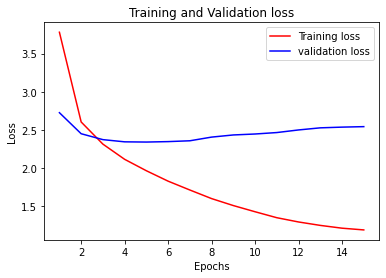

In [ ]:
loss_train = trainer['trainning_loss']
loss_val = trainer['eval_loss']
epochs = trainer['epoch']
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

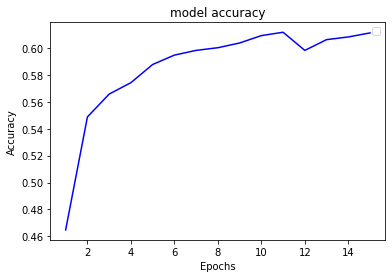

In [ ]:

accuracy_validation = trainer['eval_accuracy']
epochs = trainer['epoch']
plt.plot(epochs, accuracy_validation, 'b')

plt.title('model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model = MultimodalVQAModel("dmis-lab/biobert-v1.1", "microsoft/swin-tiny-patch4-window7-224")

# We use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Sihem Jouini /VQA-Med2019/checkpoint/checkpoint-4400/pytorch_model.bin")))
model.to(device) 

Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MultimodalVQAModel(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis